In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from my_gan import Generator, Discriminator

class Config:
    n_epochs = 200
    batch_size = 64
    lr = 0.0002
    b1 = 0.5        
    b2 = 0.999         
    latent_dim = 100  
    img_size = 28
    channels = 1
    sample_interval = 400

opt = Config()

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Running on device: {device}")

os.makedirs("images", exist_ok=True)

Running on device: cuda


In [6]:
dataloader = DataLoader(
    datasets.MNIST(
        "./data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

print(f"Data loaded: {len(dataloader)} batches.")

def show_images(images, title="Generated Images"):
    images = (images + 1) / 2.0
    
    grid_img = make_grid(images, nrow=5, padding=2)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

fixed_noise = torch.randn(25, opt.latent_dim).to(device)

Data loaded: 938 batches.


Starting Training Loop...
[Epoch 0/200] [Batch 0/938] [D loss: 0.6698] [G loss: 0.6978]
[Epoch 0/200] [Batch 400/938] [D loss: 0.5497] [G loss: 0.7140]
[Epoch 0/200] [Batch 800/938] [D loss: 0.5383] [G loss: 0.7522]


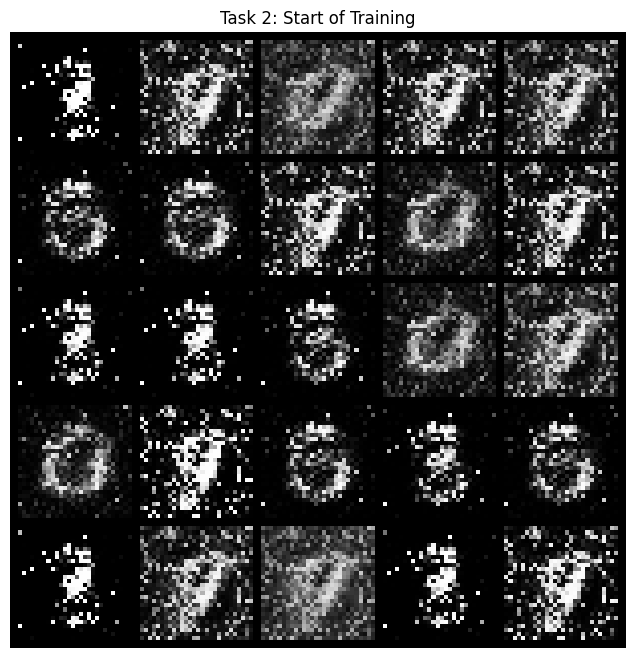

[Epoch 1/200] [Batch 262/938] [D loss: 0.5238] [G loss: 0.8927]
[Epoch 1/200] [Batch 662/938] [D loss: 0.4304] [G loss: 1.0454]
[Epoch 2/200] [Batch 124/938] [D loss: 0.4949] [G loss: 0.9791]
[Epoch 2/200] [Batch 524/938] [D loss: 0.4830] [G loss: 1.1392]
[Epoch 2/200] [Batch 924/938] [D loss: 0.4749] [G loss: 1.4523]
[Epoch 3/200] [Batch 386/938] [D loss: 0.6053] [G loss: 1.3175]
[Epoch 3/200] [Batch 786/938] [D loss: 0.5255] [G loss: 1.1486]
[Epoch 4/200] [Batch 248/938] [D loss: 0.4599] [G loss: 1.2602]
[Epoch 4/200] [Batch 648/938] [D loss: 0.5032] [G loss: 1.0482]
[Epoch 5/200] [Batch 110/938] [D loss: 0.5485] [G loss: 1.1114]
[Epoch 5/200] [Batch 510/938] [D loss: 0.5277] [G loss: 1.0184]
[Epoch 5/200] [Batch 910/938] [D loss: 0.4649] [G loss: 1.0800]
[Epoch 6/200] [Batch 372/938] [D loss: 0.5362] [G loss: 1.1368]
[Epoch 6/200] [Batch 772/938] [D loss: 0.5830] [G loss: 1.2713]
[Epoch 7/200] [Batch 234/938] [D loss: 0.5508] [G loss: 1.0273]
[Epoch 7/200] [Batch 634/938] [D loss: 0

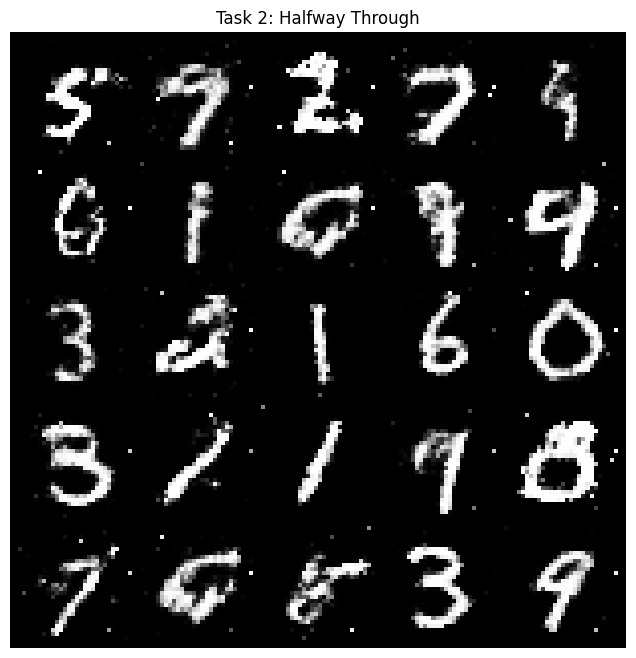

[Epoch 101/200] [Batch 62/938] [D loss: 0.6801] [G loss: 0.6991]
[Epoch 101/200] [Batch 462/938] [D loss: 0.6687] [G loss: 0.7387]
[Epoch 101/200] [Batch 862/938] [D loss: 0.6594] [G loss: 0.7839]
[Epoch 102/200] [Batch 324/938] [D loss: 0.6898] [G loss: 0.7653]
[Epoch 102/200] [Batch 724/938] [D loss: 0.6613] [G loss: 0.7528]
[Epoch 103/200] [Batch 186/938] [D loss: 0.6823] [G loss: 0.7320]
[Epoch 103/200] [Batch 586/938] [D loss: 0.6662] [G loss: 0.7447]
[Epoch 104/200] [Batch 48/938] [D loss: 0.6997] [G loss: 0.6871]
[Epoch 104/200] [Batch 448/938] [D loss: 0.6822] [G loss: 0.8236]
[Epoch 104/200] [Batch 848/938] [D loss: 0.6847] [G loss: 0.7329]
[Epoch 105/200] [Batch 310/938] [D loss: 0.6796] [G loss: 0.7569]
[Epoch 105/200] [Batch 710/938] [D loss: 0.6739] [G loss: 0.7230]
[Epoch 106/200] [Batch 172/938] [D loss: 0.6820] [G loss: 0.7816]
[Epoch 106/200] [Batch 572/938] [D loss: 0.6707] [G loss: 0.7374]
[Epoch 107/200] [Batch 34/938] [D loss: 0.6539] [G loss: 0.7489]
[Epoch 107/20

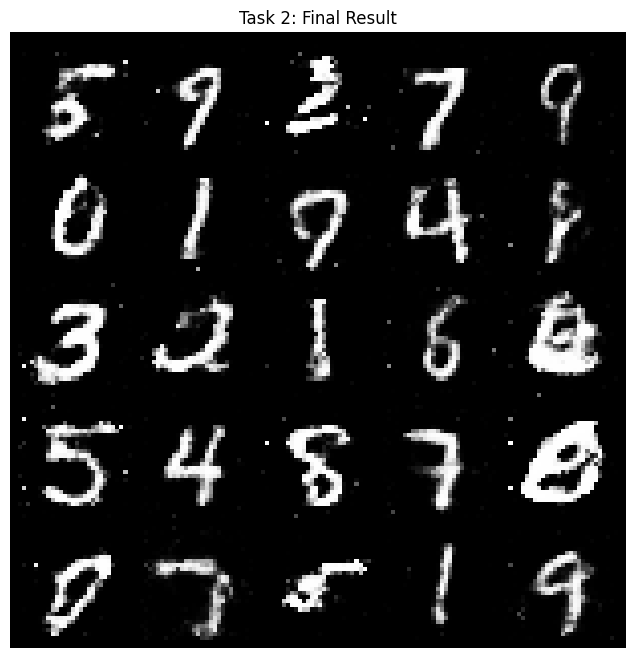

Training Finished!


In [7]:
# 初始化模型
generator = Generator().to(device)
discriminator = Discriminator().to(device)
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

G_losses = []
D_losses = []

snapshots = {} 

print("Starting Training Loop...")

for epoch in range(opt.n_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        valid = torch.ones(imgs.size(0), 1, device=device)
        fake = torch.zeros(imgs.size(0), 1, device=device)
        real_imgs = imgs.to(device)

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        z = torch.randn(imgs.size(0), opt.latent_dim, device=device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            print(
                f"[Epoch {epoch}/{opt.n_epochs}] [Batch {i}/{len(dataloader)}] "
                f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]"
            )
            
    # --- Task 2: Capture Snapshots ---
    # 1. Start of training (End of Epoch 0)
    if epoch == 0:
        with torch.no_grad():
            snapshots['Start'] = generator(fixed_noise).detach().cpu()
            show_images(snapshots['Start'], title="Task 2: Start of Training")
            
    # 2. Halfway through
    if epoch == int(opt.n_epochs / 2):
        with torch.no_grad():
            snapshots['Middle'] = generator(fixed_noise).detach().cpu()
            show_images(snapshots['Middle'], title="Task 2: Halfway Through")

torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")
print("Model saved successfully as 'generator.pth'!")

# 3. End of training
with torch.no_grad():
    snapshots['End'] = generator(fixed_noise).detach().cpu()
    show_images(snapshots['End'], title="Task 2: Final Result")

print("Training Finished!")

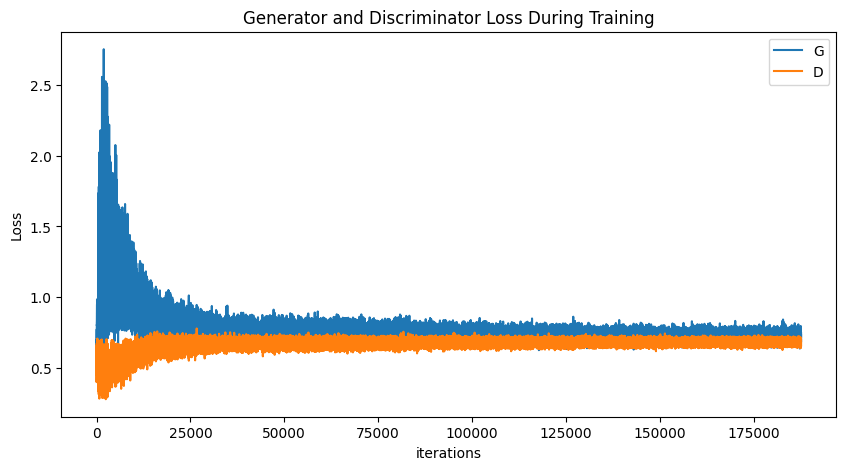

In [8]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()